# Word2Vec - CBOW

Based on lab [notebook](https://github.com/aeau/MAU-AML-labs/blob/develop/2-language-models-lab/1-word2vec.ipynb) provided.


This notebook covers:
1. Continuous Bag Of Words Model

## Imports & Setup

In [11]:
import math
import torch
import torch.linalg
import matplotlib.pyplot as plt

import plotly.express as px
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Defining Helper functions 

In [12]:
def create_dataset(text: list, context_size: int):
    data = []
    for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
        context = []
        for j in range(CONTEXT_SIZE, 0, -1):
            context.append(raw_text[i - j])

        for j in range(1, CONTEXT_SIZE + 1):
            context.append(raw_text[i + j])
            
        target = raw_text[i]
        data.append((context, target))
    return data

def make_context_vector(context, word_to_ix, debug=False):
    if debug:
      print(context)
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

## Preparation 

In [13]:
raw_text= """Long Short-Term Memory (LSTM) is a recurrent neural network (RNN) architecture that has been designed
to address the vanishing and exploding gradient problems of conventional RNNs. Unlike feedforward neural networks,
RNNs have cyclic connections making them powerful for modeling sequences. 
They have been successfully used for sequence labeling and sequence prediction tasks,
such as handwriting recognition, language modeling, phonetic labeling of acoustic frames. However, in contrast to the deep neural
networks, the use of RNNs in speech recognition has been limited to phone recognition in small scale tasks. 
In this paper, we present novel LSTM based RNN architectures which make more effective
use of model parameters to train acoustic models for large vocabulary speech recognition. 
We train and compare LSTM, RNN and DNN models at various numbers of parameters and configurations.
We show that LSTM models converge quickly and give state of the art speech recognition performance for relatively small sized models.""".split()

vocab = set(raw_text)
vocab_size = len(vocab)
word_to_index = {word: i for i, word in enumerate(vocab)}

print('num total words: ', len(raw_text))
print('Num unique words: ', vocab_size)

num total words:  152
Num unique words:  106


## Hyperparameter 


In [14]:
CONTEXT_SIZE = 2
VOCAB_SIZE = vocab_size
EMBEDD_DIM = 10
BATCH_SIZE = 6
FULL_CONTEXT_SIZE = CONTEXT_SIZE * 2
HIDDEN_SIZE = 256

## Defining CBOW Model

In [15]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embed_dim, context, hidden_size):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(context*embed_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, vocab_size),
            nn.LogSoftmax(dim = -1)
        )
        
    def forward(self, inputs):
        out = self.embedding(inputs)
        out = out.view(1, -1)
        out = self.linear(out)
        return out

    def get_word_vector(self, word):
        out = self.embedding(word)
        return out

    def get_embedding(self, word_index):
        wi = torch.tensor([word_index]).to(device)
        return self.embedding(wi).view(1,-1)

## Defining Train function 

In [16]:
def train(model, epochs, data, optimizer, criterion):
    model.train()
    losses = []
    for _ in range(epochs):
        total_loss = 0
        for context, target in data:

            # Prepare inputs and targets 
            context_idxs = make_context_vector(context, word_to_index)
            context_idxs = context_idxs.to(device)
            target_id = make_context_vector([target], word_to_index)
            target_id = target_id.to(device)

            # Do not accumulate 
            model.zero_grad()

            # Step 3. Run the forward pass
            log_probs = model(context_idxs)

            # Step 4. Compute your loss function.
            loss = criterion(log_probs, target_id)


            # Step 5. Do the backward pass and update the gradient
            loss.backward()
            optimizer.step()

            # Get the Python number from a 1-element Tensor by calling tensor.item()
            total_loss += loss.item()
        losses.append(total_loss)
    return losses

## Training CBOW Model

In [17]:
datset = create_dataset(raw_text, CONTEXT_SIZE)

criterion = nn.NLLLoss()
model = CBOW(VOCAB_SIZE, EMBEDD_DIM, FULL_CONTEXT_SIZE, HIDDEN_SIZE)
model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)

losses = train(model, 100, datset, optimizer, criterion)

In [18]:
fig = px.line(losses, title="Loss")
fig.update_layout(
    xaxis_title="Epoch",
    yaxis_title="Loss",)
fig.show()

In [19]:
def similarity_cbow(word_1, word_2):
    
    # test word similarity
    print(word_1)
    print(word_2)
    w1_id = torch.tensor(word_to_index[word_1], dtype=torch.long)
    w2_id = torch.tensor(word_to_index[word_2], dtype=torch.long)
    w1_id = w1_id.to(device)
    w2_id = w2_id.to(device)
    
    word_1_vec = model.get_word_vector(w1_id)
    word_2_vec = model.get_word_vector(w2_id)
    
    # The norm of a vector (1D-matrix) is the square root of the sum of all the squared values within the vector.
    print(math.sqrt(torch.square(word_1_vec).sum()))    
    print(torch.linalg.norm(word_1_vec))
    print(torch.linalg.norm(word_2_vec))
    print(word_1_vec.dot(word_2_vec))
    
    word_distance = torch.linalg.norm(word_1_vec - word_2_vec)
    print("Distance between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_distance))
    word_similarity = (word_1_vec.dot(word_2_vec) / (torch.linalg.norm(word_1_vec) * torch.linalg.norm(word_2_vec)))
    print("Similarity between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_similarity))


similarity_cbow("neural", "network")

neural
network
3.6370749785671506
tensor(3.6371, grad_fn=<LinalgVectorNormBackward0>)
tensor(1.9752, grad_fn=<LinalgVectorNormBackward0>)
tensor(-3.8827, grad_fn=<DotBackward0>)
Distance between 'neural' & 'network' : 4.9895
Similarity between 'neural' & 'network' : -0.5405


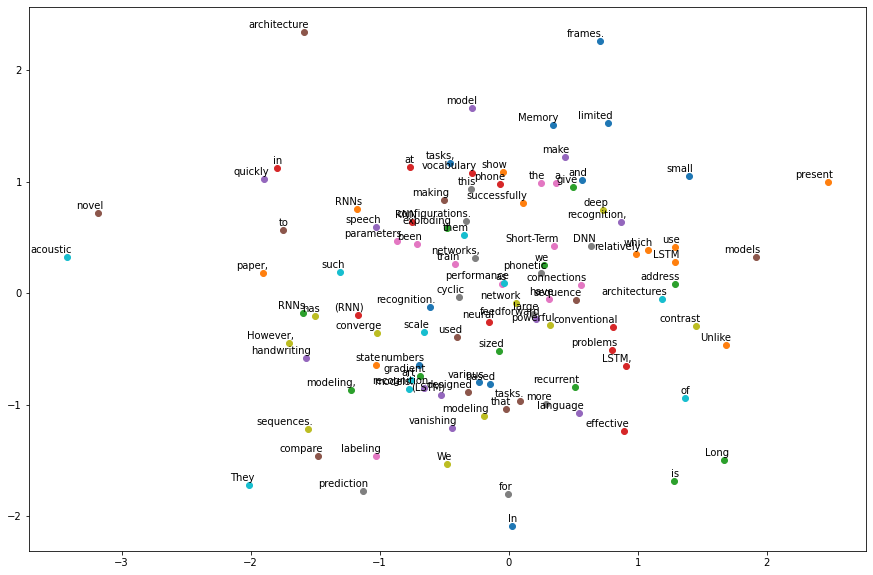

In [20]:
plt.figure(figsize=(15,10))
for w in vocab:
    x = model.get_embedding(word_to_index[w]).detach().data.cpu().numpy()[0][0]
    y = model.get_embedding(word_to_index[w]).detach().data.cpu().numpy()[0][1]
    plt.scatter(x, y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

In [21]:
def predict_middle_word(prev_words, post_words):
    
    key_list = list(word_to_index.keys())
    val_list = list(word_to_index.values())

    prev_words = prev_words.split()
    post_words = post_words.split()

    input_words= make_context_vector(prev_words + post_words, word_to_index)
    input_words = input_words.to(device)
    output = model(input_words)
    out_ind = output.argmax(1)
    out_word = key_list[val_list.index(out_ind.item())]
    print(prev_words, out_word, post_words)

predict_middle_word("a recurrent", "network is")
predict_middle_word("LSTM is", "recurrent neural")

['a', 'recurrent'] and ['network', 'is']
['LSTM', 'is'] RNN ['recurrent', 'neural']
